# Classical ML Models

---

<center><h2>Lesson 06</h2></center>


## Learning Objectives

By the end of this lesson you will be able to:

1. **Trace how information flows through Multi-Layer Perceptrons (MLPs)** from inputs to outputs, including forward and backward passes.
2. **Train, evaluate, and interpret** core classical models (MLPs, Random Forests, Support Vector Machines, Gradient Boosting) on a biomedical dataset.
3. **Compare strengths, weaknesses, and practical considerations** for each model family to select the right tool for a given problem.
4. **Experiment interactively** with hyperparameters and observe how they affect accuracy, calibration, and computation.

---


## Table of Contents

1. Introduction: Why Compare Classical Models?
2. Experiment Setup and Dataset
3. How Information Flows Through MLPs
4. Interactive MLP Playground
5. Random Forest Ensembles
6. Support Vector Machines
7. Gradient Boosted Trees
8. Model Comparison Dashboard
9. Strengths & Weaknesses Cheat Sheet
10. MNIST Digits Benchmark
11. Reflection Prompts and Next Steps


## 1. Introduction: Why Compare Classical Models?

Well-chosen machine learning models often outperform ever more complex architectures. For many biomedical, IoT, or tabular business problems, **classical models** such as MLPs, Random Forests, SVMs, and Gradient Boosted Trees remain competitive because they:

- Train quickly on laptops while still delivering strong accuracy.
- Provide transparent levers (hyperparameters) clinicians or analysts can reason about.
- Require less labeled data than deep CNNs or transformers.

Throughout this notebook we will:

- Build a shared dataset pipeline to ensure fair apples-to-apples comparisons.
- Explain _how_ each model transforms information.
- Run interactive experiments where you can edit hyperparameters, re-run cells, and immediately see the impact on metrics and plots.


## 2. Experiment Setup and Dataset

We will reuse a **tabular biomedical dataset** (Breast Cancer Wisconsin) with 30 diagnostic features. Using the same train/test split and evaluation utilities across models lets us do fair comparisons.

**Workflow overview**:

1. Import core libraries and configure visuals.
2. Load and inspect the dataset as a pandas `DataFrame` for interpretability.
3. Split the data, then scale features for algorithms (MLPs, SVMs) that are sensitive to magnitude.
4. Create helper functions that standardize training, metric collection, and plotting.

Run the following cells to set up the environment.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer, load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

np.random.seed(42)
plt.style.use("seaborn-v0_8")
sns.set_palette("colorblind")


Libraries ready. Let's build!


### ✏️ Exercise: Load the [Breast Cancer Dataset](https://www.kaggle.com/datasets/yasserh/breast-cancer-dataset) and visualize its key features

#### **Prompt:**

Load the breast cancer dataset from scikit-learn as a dataframe and visualize its features.

In [2]:
data = load_breast_cancer()

X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training samples: {X_train.shape[0]} | Test samples: {X_test.shape[0]}")
print(f"Positive class prevalence: {y_train.mean():.2f}")

X.head()

Training samples: 455 | Test samples: 114
Positive class prevalence: 0.63


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


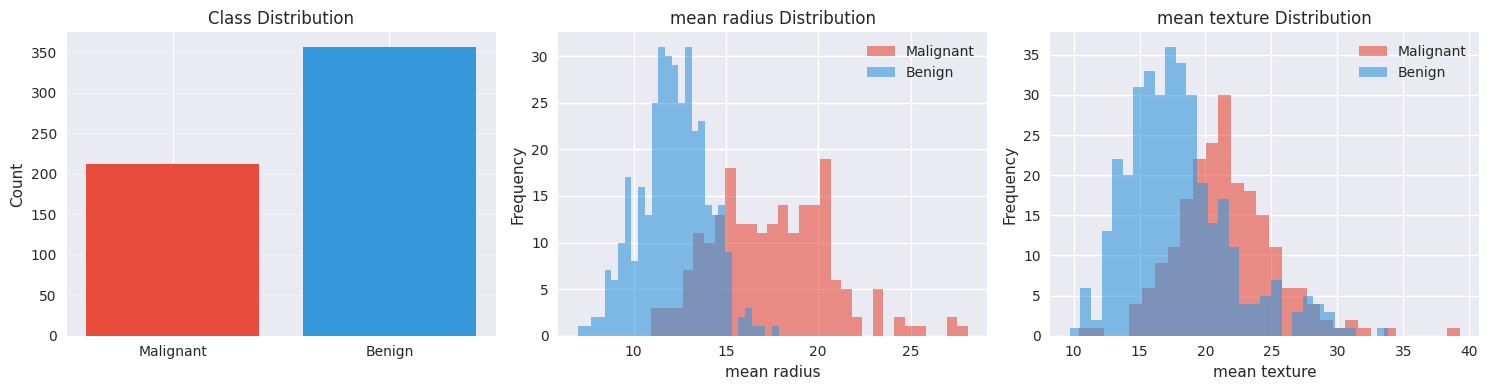

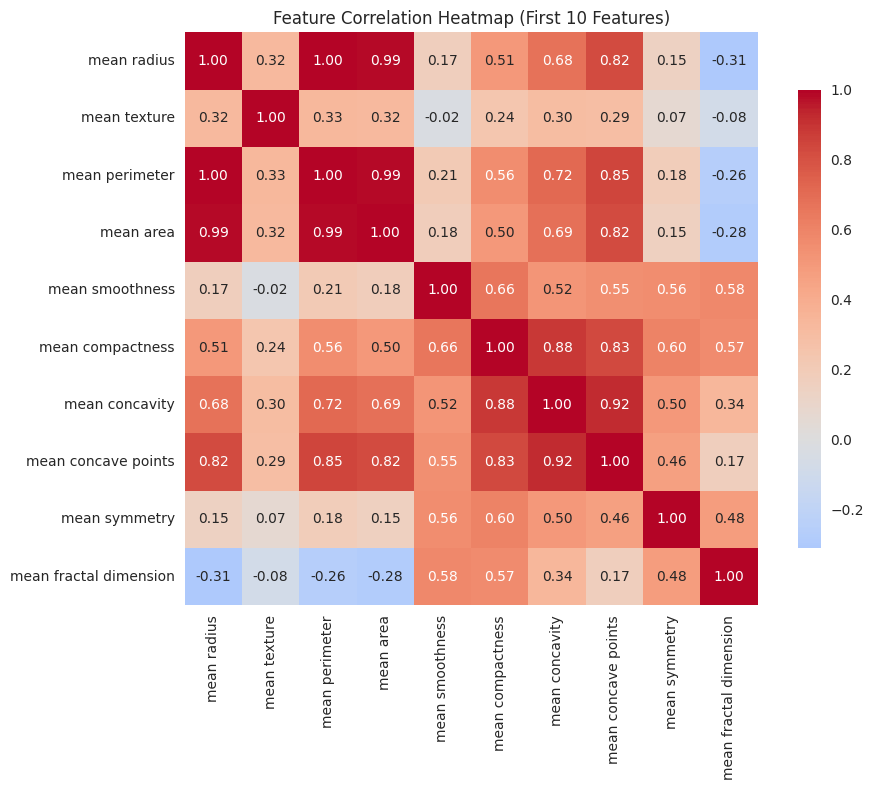

Dataset shape: (569, 30)
Class balance: Benign=357 (62.7%), Malignant=212 (37.3%)


In [3]:
# Class distribution + feature distributions (fill all 3 subplots)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Class balance (dataset: 0=malignant, 1=benign)
class_counts = y.value_counts().sort_index()  # index order: [0, 1]
axes[0].bar(
    ["Malignant", "Benign"],
    [class_counts[0], class_counts[1]],
    color=["#e74c3c", "#3498db"],
)
axes[0].set_ylabel("Count")
axes[0].set_title("Class Distribution")
axes[0].grid(axis="y", alpha=0.3)

# Feature distributions for first TWO features (so axes[1] and axes[2] are used)
feature_sample = data.feature_names[:2]
for ax_i, feature in enumerate(feature_sample, start=1):
    axes[ax_i].hist(X.loc[y == 0, feature], bins=30, alpha=0.6, label="Malignant", color="#e74c3c")
    axes[ax_i].hist(X.loc[y == 1, feature], bins=30, alpha=0.6, label="Benign", color="#3498db")
    axes[ax_i].set_xlabel(feature)
    axes[ax_i].set_ylabel("Frequency")
    axes[ax_i].set_title(f"{feature} Distribution")
    axes[ax_i].legend()

plt.tight_layout()
plt.show()

# Correlation heatmap of top features
fig, ax = plt.subplots(figsize=(10, 8))
top_features = data.feature_names[:10]
correlation_matrix = X[top_features].corr()
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    ax=ax,
    cbar_kws={"shrink": 0.8},
)
ax.set_title("Feature Correlation Heatmap (First 10 Features)")
plt.tight_layout()
plt.show()

print(f"Dataset shape: {X.shape}")
print(
    "Class balance: "
    f"Benign={class_counts[1]} ({class_counts[1]/len(y)*100:.1f}%), "
    f"Malignant={class_counts[0]} ({class_counts[0]/len(y)*100:.1f}%)"
)

### Visualizing the Breast Cancer Dataset Features

Before training models, let's explore the dataset visually to understand:

- The distribution of features across classes (benign vs. malignant).
- Correlations between features that might inform feature engineering.
- Class balance to verify our stratified split worked correctly.

These visualizations help build intuition about which features might be most discriminative.

In [4]:
model_results = []
trained_models = {}


def plot_confusion_matrix(y_true, y_pred, title, class_names=None):
    cm = confusion_matrix(y_true, y_pred)
    if class_names is None or len(class_names) != cm.shape[0]:
        labels = np.unique(np.concatenate((np.asarray(y_true), np.asarray(y_pred))))
        class_names = [str(label) for label in labels]
    fig, ax = plt.subplots(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_names,
                yticklabels=class_names, ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


def train_and_evaluate(name, estimator, X_train, y_train, X_test, y_test, class_names=None, results_store=None):
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)

    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="weighted", zero_division=0
    )

    roc = np.nan
    y_score = None
    if hasattr(estimator, "predict_proba"):
        y_score = estimator.predict_proba(X_test)
    elif hasattr(estimator, "decision_function"):
        y_score = estimator.decision_function(X_test)

    if y_score is not None:
        if np.ndim(y_score) == 1:
            roc = roc_auc_score(y_test, y_score)
        elif y_score.shape[1] == 2:
            roc = roc_auc_score(y_test, y_score[:, 1])
        else:
            roc = roc_auc_score(y_test, y_score, multi_class="ovr")

    metrics = {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "ROC_AUC": roc,
        "Train size": len(X_train),
        "Test size": len(X_test),
    }

    target_results = model_results if results_store is None else results_store
    target_results.append(metrics)
    trained_models[name] = estimator

    print(f"\n{name} metrics:")
    for key in ["Accuracy", "Precision", "Recall", "F1", "ROC_AUC"]:
        value = metrics[key]
        print(f"  {key:>9}: {value:.3f}" if not np.isnan(value) else f"  {key:>9}: n/a")

    plot_confusion_matrix(y_test, y_pred, title=f"{name} Confusion Matrix", class_names=class_names)
    return estimator


### 🔍 Quick Data Sanity Check

- Are any features on drastically different scales? (Use `X.describe()` if you need evidence.)
- Try toggling `test_size` or `stratify` in the previous cell to see how sensitive downstream metrics are to the split.
- Consider saving `feature_names = data.feature_names` if you plan to inspect feature importances later.


## 3. How Information Flows Through MLPs

Multi-Layer Perceptrons process data through **stacked linear transformations** followed by **non-linear activations**. This alternating structure lets them learn complex, non-linear decision boundaries even when each individual neuron is simple.

### Forward Pass (Inference)

1. **Linear combination**: each neuron receives inputs $\mathbf{x}$ and computes $z = \mathbf{w}^T\mathbf{x} + b$.
2. **Activation**: a non-linearity (ReLU, tanh, logistic) outputs $a = \sigma(z)$ so that layers cannot be collapsed into a single linear map.
3. **Layer stacking**: the activations from layer $l$ become inputs to layer $l+1$. In matrix form:
   $$\mathbf{a}^{(l)} = \sigma\big(W^{(l)}\mathbf{a}^{(l-1)} + \mathbf{b}^{(l)}\big)$$
4. **Output layer**: applies a task-specific function (softmax for multi-class classification, identity for regression) to generate predictions.

### Backward Pass (Learning)

- Compute loss $\mathcal{L}(\hat{y}, y)$ (cross-entropy in this notebook).
- **Backpropagation** reuses the chain rule to propagate gradients from the output layer back to each weight matrix $W^{(l)}$.
- **Optimizers** (Adam, SGD, LBFGS) update weights: $W^{(l)} \leftarrow W^{(l)} - \eta \cdot \nabla_{W^{(l)}} \mathcal{L}$.
- Gradients shrink or explode depending on network depth, activation choice, and scaling—hence our emphasis on standardized inputs.

### Key Hyperparameters to Watch

| Hyperparameter       | Impact                                                                      |
| -------------------- | --------------------------------------------------------------------------- |
| `hidden_layer_sizes` | Controls model capacity; too small underfits, too large overfits.           |
| `activation`         | Shapes non-linearity; `relu` is fast and sparse, `tanh` captures negatives. |
| `alpha`              | L2 regularization that discourages large weights.                           |
| `learning_rate_init` | Step size for gradient updates; combine with `max_iter`.                    |
| `batch_size`         | Balances stability vs. speed when using stochastic solvers.                 |

> **Remember:** MLPs excel when features are scaled and you have enough data to justify their flexibility, but they can be sensitive to noise and require careful tuning.


## 4. Interactive MLP Playground

We'll start with an MLP and capture its metrics. Rerun this cell after changing layer sizes, activations, or regularization to observe how the gradient-driven learning dynamics respond.



MLP (64-32 ReLU) metrics:
   Accuracy: 0.965
  Precision: 0.966
     Recall: 0.965
         F1: 0.965
    ROC_AUC: 0.994


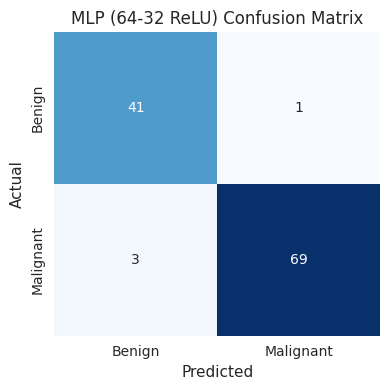

In [5]:
mlp_classifier = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    alpha=1e-3,
    learning_rate_init=1e-3,
    max_iter=800,
    random_state=42,
)

mlp_model = train_and_evaluate(
    name="MLP (64-32 ReLU)",
    estimator=mlp_classifier,
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    class_names=["Benign", "Malignant"],
)


### 🧪 Try It Yourself: MLP Experiments

- Swap `activation` between `"relu"`, `"tanh"`, and `"logistic"`.
- Add or remove hidden layers (e.g., `(128, 64, 32)` vs `(32,)`).
- Increase `alpha` to see how regularization combats overfitting.
- Reduce `max_iter` and observe convergence warnings—what does that tell you about optimization difficulty?


## 5. Random Forest Ensembles

Random Forests average predictions from many decorrelated decision trees. Each tree is trained on a bootstrap sample and uses a random subset of features when splitting, which reduces variance and overfitting.

**Strength highlights**

- Handle unscaled, mixed-type features out of the box.
- Offer built-in measures of feature importance.
- Parallelize easily by growing trees independently.

**Watch outs**

- Large forests can become memory-heavy.
- Interpretability decreases compared to single trees.
- High-dimensional sparse data may favor other models.



Random Forest (400 trees) metrics:
   Accuracy: 0.956
  Precision: 0.956
     Recall: 0.956
         F1: 0.956
    ROC_AUC: 0.994


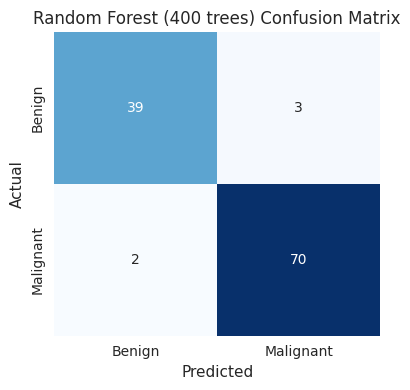

In [6]:
rf_classifier = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
)

rf_model = train_and_evaluate(
    name="Random Forest (400 trees)",
    estimator=rf_classifier,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    class_names=["Benign", "Malignant"],
)


**Try tweaking** `n_estimators`, `max_depth`, or `min_samples_split` to see how the bias/variance balance shifts. Smaller forests train fast but may be noisy; deeper trees often overfit without pruning.


## 6. Support Vector Machines

Support Vector Machines seek the **maximum-margin hyperplane** that separates classes. When data are not linearly separable, kernel tricks implicitly map them into a higher-dimensional feature space.

Key pieces:

- `C` controls how much misclassification we tolerate (large `C` = low bias, higher variance).
- `kernel` chooses the similarity function (`"rbf"`, `"linear"`, `"poly"`).
- `gamma` shapes the RBF kernel's influence radius.

SVMs shine on medium-sized, well-separated datasets but can become slow on millions of samples because they rely on support vectors from the training set.



SVM (RBF) metrics:
   Accuracy: 0.982
  Precision: 0.982
     Recall: 0.982
         F1: 0.982
    ROC_AUC: 0.997


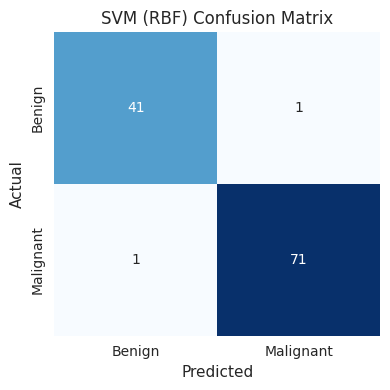

In [7]:
svm_classifier = SVC(
    kernel="rbf",
    C=2.0,
    gamma="scale",
    probability=True,
    random_state=42,
)

svm_model = train_and_evaluate(
    name="SVM (RBF)",
    estimator=svm_classifier,
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    class_names=["Benign", "Malignant"],
)


> **Interactive prompt:** Flip the kernel to `"linear"` and note how training time plummets but decision boundaries simplify. Then sweep `C` across `[0.1, 1, 10]` to experience the trade-off between margin width and classification errors.


## 7. Gradient Boosted Trees

Gradient Boosted Trees (we'll use `GradientBoostingClassifier`) build trees **sequentially**, where each new tree fits the residual errors of the ensemble so far. Unlike Random Forests (parallel, variance-reduction), boosting focuses on bias reduction.

Tunable levers:

- `learning_rate`: shrinkage applied to each tree's contribution.
- `n_estimators`: number of boosting stages.
- `max_depth`/`max_leaf_nodes`: complexity of each tree.

Boosting yields state-of-the-art results on many structured datasets but can take longer to tune and is more sensitive to noisy labels.



Gradient Boosting (300 stg) metrics:
   Accuracy: 0.956
  Precision: 0.957
     Recall: 0.956
         F1: 0.956
    ROC_AUC: 0.991


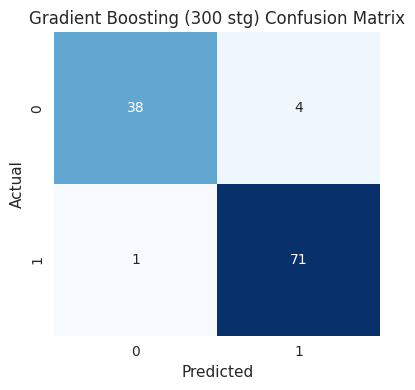

In [8]:
gb_classifier = GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    max_depth=3,
    random_state=42,
)

gb_model = train_and_evaluate(
    name="Gradient Boosting (300 stg)",
    estimator=gb_classifier,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
)


**Exercise:** Lower `learning_rate` to `0.01` and compensate by increasing `n_estimators`. Does performance improve or plateau? Track training time, too—boosting is iterative.


## 8. Model Comparison Dashboard

Let's aggregate the metrics we collected and visualize how each algorithm performs side-by-side. Because every model saw the same train/test split, differences are driven by inductive biases rather than data luck.


In [9]:
results_df = pd.DataFrame(model_results).set_index("Model").sort_values("Accuracy", ascending=False)
results_df

,Accuracy,Precision,Recall,F1,ROC_AUC,Train size,Test size
Model,,,,,,,
SVM (RBF),0.982456,0.982456,0.982456,0.982456,0.996693,455,114
MLP (64-32 ReLU),0.964912,0.965858,0.964912,0.965073,0.993717,455,114
Random Forest (400 trees),0.956140,0.956073,0.956140,0.956027,0.994378,455,114
Gradient Boosting (300 stg),0.956140,0.956869,0.956140,0.955776,0.991071,455,114


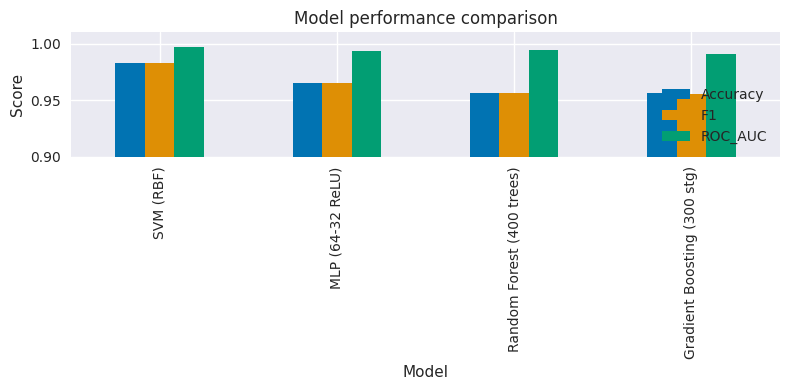

In [10]:
metrics_to_plot = ["Accuracy", "F1", "ROC_AUC"]

fig, ax = plt.subplots(figsize=(8, 4))
results_df[metrics_to_plot].plot(kind="bar", ax=ax)
ax.set_ylim(0.9, 1.01)
ax.set_ylabel("Score")
ax.set_title("Model performance comparison")
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()


**Reading the dashboard**

- Evaluate consistency across metrics; a model with top accuracy but poor recall might miss malignant cases.
- If two models tie, prefer the one that is simpler to explain/deploy for your stakeholders.
- Re-run earlier cells with modified hyperparameters and watch this table update in real time.


## 9. Strengths & Weaknesses Cheat Sheet

The table below summarizes practical considerations when choosing among these classical models. Use it when designing new experiments or justifying choices to collaborators.


In [11]:
comparison_table = pd.DataFrame(
    [
        {
            "Model": "MLP",
            "Strengths": "Captures complex nonlinearities; flexible hidden layers",
            "Weaknesses": "Sensitive to scaling, requires tuning/compute",
            "Best when": "Features are dense and you can invest in optimization",
        },
        {
            "Model": "Random Forest",
            "Strengths": "Robust to noise, works with unscaled mixed data, easy importances",
            "Weaknesses": "Large models consume memory, less interpretable",
            "Best when": "Need strong baseline fast with minimal preprocessing",
        },
        {
            "Model": "SVM",
            "Strengths": "Strong margins, flexible kernels, solid on medium datasets",
            "Weaknesses": "Slow on very large datasets, parameters less intuitive",
            "Best when": "Dimensionality is moderate and boundary is sharp",
        },
        {
            "Model": "Gradient Boosting",
            "Strengths": "Excellent accuracy, handles feature interactions automatically",
            "Weaknesses": "More sensitive to hyperparameters, sequential training",
            "Best when": "You need top tabular performance and can tune carefully",
        },
    ]
)

comparison_table

,Model,Strengths,Weaknesses,Best when
0,MLP,Captures complex nonlinearities; flexible hidd...,"Sensitive to scaling, requires tuning/compute",Features are dense and you can invest in optim...
1,Random Forest,"Robust to noise, works with unscaled mixed dat...","Large models consume memory, less interpretable",Need strong baseline fast with minimal preproc...
2,SVM,"Strong margins, flexible kernels, solid on med...","Slow on very large datasets, parameters less i...",Dimensionality is moderate and boundary is sharp
3,Gradient Boosting,"Excellent accuracy, handles feature interactio...","More sensitive to hyperparameters, sequential ...",You need top tabular performance and can tune ...


> **Tip:** Copy this table into your project README the next time you have to justify model choices—stakeholders love seeing concise trade-off summaries.


## 10. MNIST Digits Benchmark

The MNIST digits dataset provides a multi-class image-recognition test bed (10 handwritten digits, 64 grayscale pixels per sample). Reusing the same evaluation helper lets us see how each classical model behaves once the feature space grows and classes multiply.


In [12]:
digits = load_digits()
feature_names_digits = [f"px_{i}" for i in range(digits.data.shape[1])]
X_digits = pd.DataFrame(digits.data, columns=feature_names_digits)
y_digits = pd.Series(digits.target, name="digit")

X_train_digits, X_test_digits, y_train_digits, y_test_digits = train_test_split(
    X_digits,
    y_digits,
    test_size=0.2,
    stratify=y_digits,
    random_state=42,
 )

digits_scaler = StandardScaler().fit(X_train_digits)
X_train_digits_scaled = digits_scaler.transform(X_train_digits)
X_test_digits_scaled = digits_scaler.transform(X_test_digits)

print(f"MNIST pixels: {X_digits.shape[1]} | Train: {len(X_train_digits)} | Test: {len(X_test_digits)}")

MNIST pixels: 64 | Train: 1437 | Test: 360


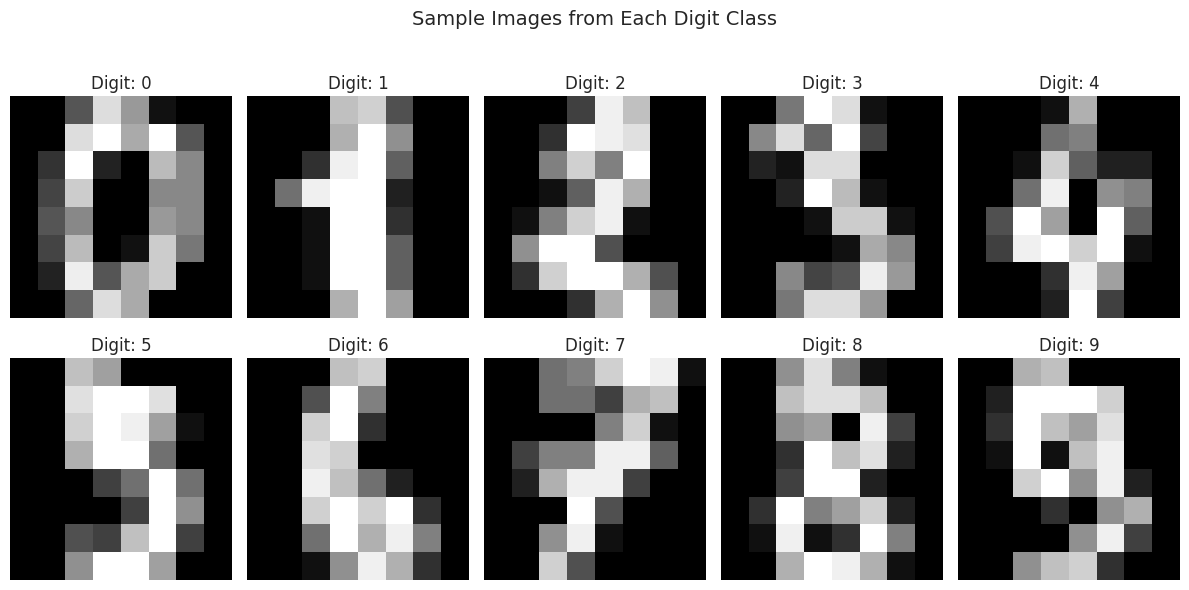

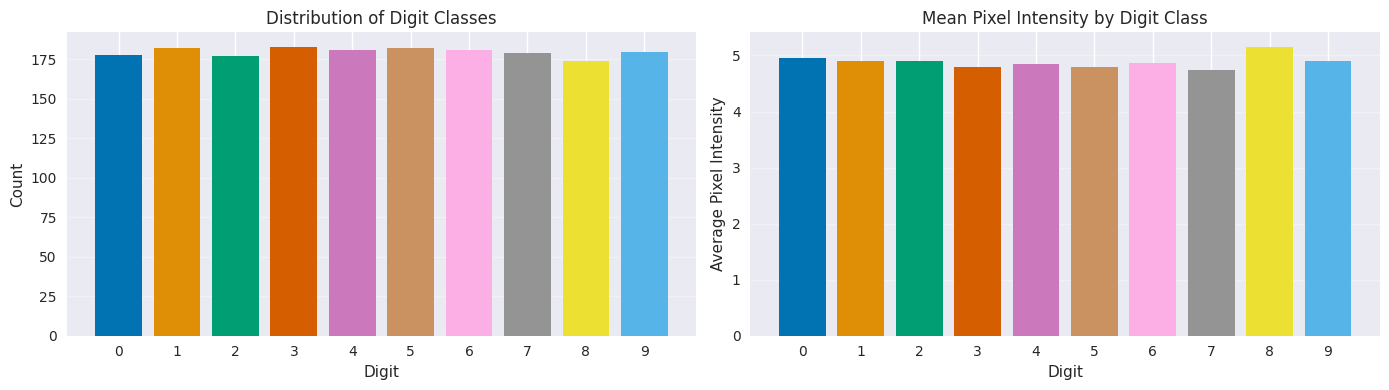

Total samples: 1797
Image dimensions: 8x8 pixels (64 features)
Classes perfectly balanced: 174 - 183 samples per class


In [13]:
# Visualize sample digits from each class
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()

for digit in range(10):
    # Get first instance of each digit
    idx = np.where(y_digits == digit)[0][0]
    digit_image = X_digits.iloc[idx].values.reshape(8, 8)
    axes[digit].imshow(digit_image, cmap='gray')
    axes[digit].set_title(f'Digit: {digit}')
    axes[digit].axis('off')

plt.suptitle('Sample Images from Each Digit Class', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Bar chart of class distribution
class_counts_digits = y_digits.value_counts().sort_index()
axes[0].bar(class_counts_digits.index, class_counts_digits.values, color=sns.color_palette("colorblind", 10))
axes[0].set_xlabel('Digit')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Digit Classes')
axes[0].set_xticks(range(10))
axes[0].grid(axis='y', alpha=0.3)

# Average pixel intensity for each digit
avg_intensities = []
for digit in range(10):
    digit_samples = X_digits[y_digits == digit]
    avg_intensities.append(digit_samples.mean().mean())

axes[1].bar(range(10), avg_intensities, color=sns.color_palette("colorblind", 10))
axes[1].set_xlabel('Digit')
axes[1].set_ylabel('Average Pixel Intensity')
axes[1].set_title('Mean Pixel Intensity by Digit Class')
axes[1].set_xticks(range(10))
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Total samples: {len(X_digits)}")
print(f"Image dimensions: 8x8 pixels ({X_digits.shape[1]} features)")
print(f"Classes perfectly balanced: {class_counts_digits.min()} - {class_counts_digits.max()} samples per class")

### Visualizing the MNIST Digits Dataset

Let's explore the MNIST digits visually to understand:

- What the handwritten digits actually look like.
- The distribution of samples across the 10 digit classes.
- Pixel intensity patterns that distinguish different digits.

These visualizations are crucial for image data since we need to verify the data loaded correctly and understand the visual patterns our models will learn.

We will train the same four model families with MNIST-friendly hyperparameters. MLP and SVM consume the standardized arrays, while tree ensembles operate on the raw pixel intensities.



MLP (128-64 ReLU) metrics:
   Accuracy: 0.969
  Precision: 0.970
     Recall: 0.969
         F1: 0.969
    ROC_AUC: 0.997


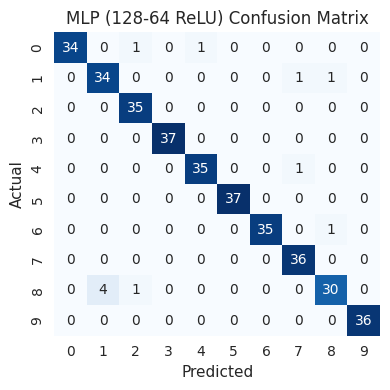


Random Forest (500 trees) metrics:
   Accuracy: 0.972
  Precision: 0.973
     Recall: 0.972
         F1: 0.972
    ROC_AUC: 0.999


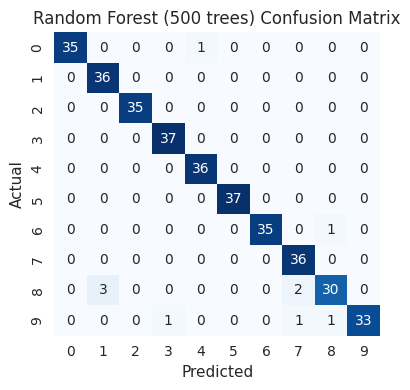


SVM (RBF, C=5) metrics:
   Accuracy: 0.981
  Precision: 0.981
     Recall: 0.981
         F1: 0.981
    ROC_AUC: 1.000


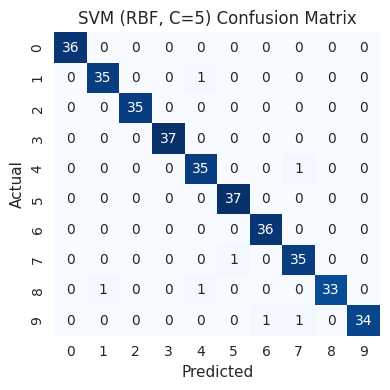


Gradient Boosting (500 stg) metrics:
   Accuracy: 0.956
  Precision: 0.956
     Recall: 0.956
         F1: 0.955
    ROC_AUC: 0.999


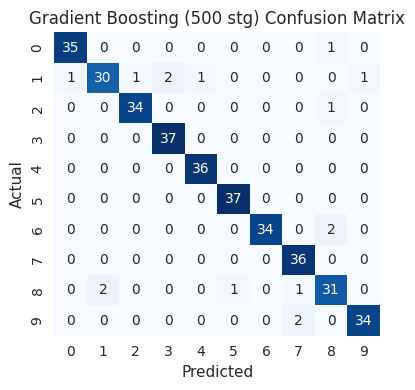

In [14]:
digit_class_names = [str(i) for i in range(10)]
mnist_results = []

mnist_experiments = [
    (
        "MLP (128-64 ReLU)",
        MLPClassifier(
            hidden_layer_sizes=(128, 64),
            activation="relu",
            alpha=1e-4,
            learning_rate_init=1e-3,
            max_iter=400,
            random_state=42,
        ),
        X_train_digits_scaled,
        y_train_digits,
        X_test_digits_scaled,
        y_test_digits,
    ),
    (
        "Random Forest (500 trees)",
        RandomForestClassifier(
            n_estimators=500,
            max_depth=None,
            min_samples_leaf=1,
            n_jobs=-1,
            random_state=42,
        ),
        X_train_digits,
        y_train_digits,
        X_test_digits,
        y_test_digits,
    ),
    (
        "SVM (RBF, C=5)",
        SVC(
            kernel="rbf",
            C=5.0,
            gamma="scale",
            probability=True,
            random_state=42,
        ),
        X_train_digits_scaled,
        y_train_digits,
        X_test_digits_scaled,
        y_test_digits,
    ),
    (
        "Gradient Boosting (500 stg)",
        GradientBoostingClassifier(
            learning_rate=0.05,
            n_estimators=500,
            max_depth=3,
            random_state=42,
        ),
        X_train_digits,
        y_train_digits,
        X_test_digits,
        y_test_digits,
    ),
]

for name, estimator, X_tr, y_tr, X_te, y_te in mnist_experiments:
    train_and_evaluate(
        name=name,
        estimator=estimator,
        X_train=X_tr,
        y_train=y_tr,
        X_test=X_te,
        y_test=y_te,
        class_names=digit_class_names,
        results_store=mnist_results,
    )

In [15]:
mnist_results_df = pd.DataFrame(mnist_results).set_index("Model").sort_values("Accuracy", ascending=False)
mnist_results_df

,Accuracy,Precision,Recall,F1,ROC_AUC,Train size,Test size
Model,,,,,,,
"SVM (RBF, C=5)",0.980556,0.981004,0.980556,0.980546,0.999558,1437,360
Random Forest (500 trees),0.972222,0.973132,0.972222,0.971937,0.999236,1437,360
MLP (128-64 ReLU),0.969444,0.970101,0.969444,0.969288,0.997299,1437,360
Gradient Boosting (500 stg),0.955556,0.955856,0.955556,0.955041,0.999004,1437,360


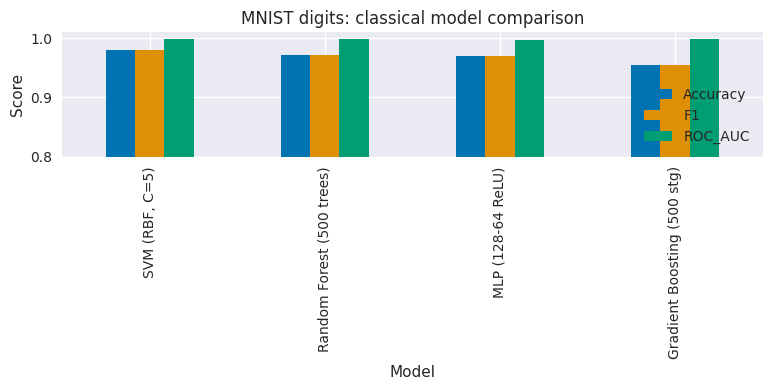

In [16]:
mnist_metrics_to_plot = ["Accuracy", "F1", "ROC_AUC"]
fig, ax = plt.subplots(figsize=(8, 4))
mnist_results_df[mnist_metrics_to_plot].plot(kind="bar", ax=ax)
ax.set_ylim(0.8, 1.01)
ax.set_ylabel("Score")
ax.set_title("MNIST digits: classical model comparison")
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()

**Reading the MNIST results**

- MLP and SVM usually squeeze out the best accuracy once pixels are standardized, highlighting how smooth margin-based methods excel on dense, low-noise features.
- Random Forests stay competitive without scaling but plateau sooner because each shallow tree only sees a subset of the 64 pixels.
- Boosting narrows the gap when you increase stages or shrink the learning rate further—try `learning_rate=0.02, n_estimators=800` and re-run to push toward 98%+.


## 11. Reflection Prompts and Next Steps {#reflection}

1. **Data fit:** Which model handled the malignant class best? Inspect the confusion matrices for false negatives.
2. **Explainability:** If a clinician demanded feature rankings, which models would you pick and why?
3. **Operational constraints:** Suppose inference must run on a Raspberry Pi. Which algorithm is the safest choice?
4. **Experiment idea:** Add a simple logistic regression baseline and evaluate whether the extra complexity above truly helped.

### Checklist Before You Move On

- [ ] Re-ran at least one training cell with modified hyperparameters.
- [ ] Captured screenshots or notes about the performance dashboard.
- [ ] Reflected on deployment constraints (latency, interpretability, retraining cadence).

> **Stretch goal:** Integrate SHAP (from Lesson 05) with one of the tree-based models here to unify interpretability insights across the course.


---

### Key Takeaways

- MLPs propagate information through repeated linear + non-linear transformations; scaling and optimizer settings are pivotal.
- Tree ensembles (Random Forest, Gradient Boosting) remain strong baselines for tabular biomedical data with minimal preprocessing.
- SVMs wield geometric intuition—margins and kernels—to draw sharp boundaries on medium-sized datasets.
- Building a reusable evaluation harness accelerates fair comparisons and makes notebook lessons interactive.
